### Load packages
First we need to load the python packages that are required to perform the analysis

In [29]:
%matplotlib inline
import os
import rasterio
import numpy 
import pandas
import scipy.io # to load the matlab files
from tqdm import tqdm
from DamageScanner import DamageScanner # the tool to estimate the losses
import matplotlib.pyplot as plt

data_path = os.path.join('..','Data')

In [3]:
# function to load DDM data
def read_DDM_input(DDM_data_path):
    DDM_data = {}
    DDM_data['Curves_structure'] = pandas.read_excel(DDM_data_path,sheet_name='curves_structure').values
    DDM_data['Curves_content'] = pandas.read_excel(DDM_data_path,sheet_name='curves_content').values
    DDM_data['MaxDam_structure'] = pandas.read_excel(DDM_data_path,sheet_name='maxdam_structure').values
    DDM_data['MaxDam_content'] = pandas.read_excel(DDM_data_path,sheet_name='maxdam_content').values  
    
    return DDM_data

### Create a function to calculate the risk

In [22]:
def risk(timeframe='current'):

    # Set paths to data and load initial data
    DDM_data = read_DDM_input(os.path.join(data_path,'DDM_data.xlsx')) # the depth-damage curves and maximum damages
    landuse_map = os.path.join(data_path,'landuse.asc') # the land-use map
    inundation_maps = scipy.io.loadmat(os.path.join(data_path,'Waterdepth_{}.mat'.format(timeframe))) # the inundation files for the current situation
 
    return_periods = [10,100,1000,2000,4000,10000]
    
    damages = []
    for return_period in tqdm(return_periods):
        if timeframe == 'current':
            inun_map = 'a0_{}'.format(return_period)
        elif timeframe == '2100':
            inun_map = 'a2_{}'.format(return_period)
            
        damage_structure,damagebin_structure = DamageScanner(landuse_map,inundation_maps[inun_map],DDM_data['Curves_structure'],
                                                         DDM_data['MaxDam_structure'])

        # run the DamageScanner for the content
        damage_content,damagebin_content = DamageScanner(landuse_map,inundation_maps[inun_map],DDM_data['Curves_content'],
                                                             DDM_data['MaxDam_content'])
        
        damages.append(damage_content+damage_structure)
        
    return numpy.trapz(damages[::-1],[1/x for x in return_periods][::-1]),damages[::-1]

### Run the function to calculate the risk

In [23]:
EAD_current,Damages_current = risk(timeframe='current')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.65it/s]


In [24]:
EAD_future,Damages_future = risk(timeframe='2100')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


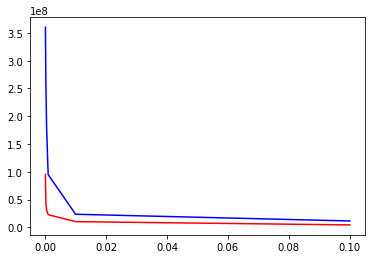

In [30]:
x = [1/10000,1/4000,1/2000,1/1000,1/100,1/10]

# red dashes, blue squares and green triangles
plt.plot(x, Damages_current, 'r', x, Damages_future, 'b')
plt.show()